# Power density spectrum

Control: disconnected vs. connected

* Do harmonics disappear when disconnected ?
* are they related with spike collision ?

Chat with Anton Sirota (Bernstein)

### Setup

Activate `npx_10m_384ch_unit_classes` venv

In [1]:
# import libs
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import scipy
import spikeinterface.extractors as se 
from matplotlib import pyplot as plt
import matplotlib
import spikeinterface as si
import spikeinterface.preprocessing as spre

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.study import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

### Setup datasets

In [16]:
# NPX-32CH (1 col)
EXPERIMENT_32 = "silico_neuropixels"
SIMULATION_DATE_32 = "2023_02_19"
data_conf_32, param_conf_32 = get_config(EXPERIMENT_32, SIMULATION_DATE_32).values() # confs
RAW_RECORDING_PATH_32 = data_conf_32["recording"]["output"]
PREPRO_PATH_32 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/preprocessed/npx32/traces"
POWER_PATH_32 = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/2_bernstein_2023/realism/power/npx32/"
N_CONTACTS_32 = 32
SAMP_FREQ_32 = 10000


# NPX-32CH (1 col)
EXPERIMENT_32_DISCO = "silico_neuropixels"
SIMULATION_DATE_32_DISCO = "2023_10_01"
data_conf_32_disco, param_conf_32_disco = get_config(EXPERIMENT_32_DISCO, SIMULATION_DATE_32_DISCO).values() # confs
RAW_RECORDING_PATH_32_DISCO = data_conf_32_disco["recording"]["output"]
PREPRO_PATH_32_DISCO = data_conf_32_disco["preprocessing"]["output"]["trace_file_path"]
POWER_PATH_32_DISCO = "/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/3_sfn_2023/realism/power/npx32_discon/"
N_CONTACTS_32_DISCO = 32
SAMP_FREQ_32_DISCO = 10000

2023-10-09 14:47:43,100 - root - utils.py - get_config - INFO - Reading experiment config.
2023-10-09 14:47:43,139 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-10-09 14:47:43,140 - root - utils.py - get_config - INFO - Reading experiment config.
2023-10-09 14:47:43,153 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [17]:
raw_32 = si.load_extractor(RAW_RECORDING_PATH_32)
raw_32_disco = si.load_extractor(RAW_RECORDING_PATH_32_DISCO)

In [18]:
# load preprocessed traces
prepro_32 = si.load_extractor(PREPRO_PATH_32)
prepro_32_disco = si.load_extractor(PREPRO_PATH_32_DISCO)

### Power spectrum

#### Compute

In [13]:
# # npx32

# ## takes 55 secs
# power_32, freq_32 = power.get_power(raw_32, N_CONTACTS_32, SAMP_FREQ_32)
# prepro_power_32, _ = power.get_power(prepro_32, N_CONTACTS_32, SAMP_FREQ_32)

# # save
# if not os.path.isdir(POWER_PATH_32):
#     os.makedirs(POWER_PATH_32)
# np.save(POWER_PATH_32+"power_raw.npy", power_32)       
# np.save(POWER_PATH_32+"freq.npy", freq_32)
# np.save(POWER_PATH_32+"power_prepro.npy", prepro_power_32)

### Load pre-computed

In [19]:
def downsample_power_data(data_path):
    psd = np.load(data_path+"power_raw.npy")
    psd = psd[:,::100]
    psd_pre = np.load(data_path+"power_prepro.npy")
    psd_pre = psd_pre[:,::100]
    freq = np.load(data_path+"freq.npy")
    if np.ndim(freq)>1:
        freq = freq[0,::100]
    else:
        freq = freq[::100]
    return psd, psd_pre, freq

In [20]:
# # the kernel crashes when we load all at once, so we load, compute the mean and delete
# # takes 20 secs

# npx32
power_32 = np.load(POWER_PATH_32+"power_raw.npy")
prepro_power_32 = np.load(POWER_PATH_32+"power_prepro.npy")
freq_32 = np.load(POWER_PATH_32+"freq.npy")

# npx32 disco
power_32_disco = np.load(POWER_PATH_32_DISCO+"power_raw.npy")
prepro_power_32_disco = np.load(POWER_PATH_32_DISCO+"power_prepro.npy")
freq_32_disco = np.load(POWER_PATH_32_DISCO+"freq.npy")

### Plot

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)

Plot raw power density spectra on x and y log scales

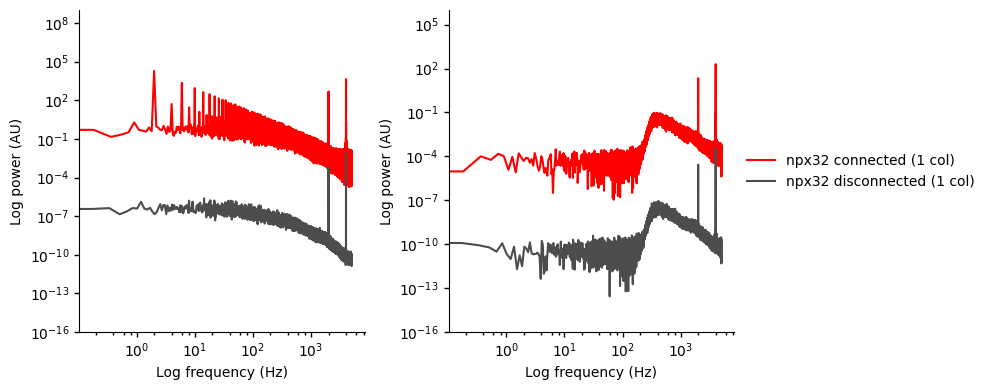

In [23]:
# takes 2 mins
fig, axes = plt.subplots(1,2,figsize=(10,4))

# connected
psd, _, freq = downsample_power_data(POWER_PATH_32)
axes[0].plot(freq, np.mean(psd, axis=0), color=[1,0,0]);
del psd; del freq

# disconnected
psd, _, freq = downsample_power_data(POWER_PATH_32_DISCO)
axes[0].plot(freq, np.mean(psd, axis=0), color=[0.3,0.3,0.3]);
del psd; del freq

axes[0].set_xlabel("Log frequency (Hz)");
axes[0].set_ylabel("Log power (AU)");
axes[0].set_yscale("log");
axes[0].set_xscale("log");
axes[0].spines[['right', 'top']].set_visible(False);
axes[0].set_ylim([1e-16, 1e9]);

# show minor ticks
axes[0].tick_params(which='both', width=1)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
axes[0].xaxis.set_major_locator(locmaj)    
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# preprocessed

# connected
_, psd_pre, freq = downsample_power_data(POWER_PATH_32)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[1,0,0], label="npx32 connected (1 col)");
del psd_pre; del freq

# 32 disconnected
_, psd_pre, freq = downsample_power_data(POWER_PATH_32_DISCO)
axes[1].plot(freq, np.mean(psd_pre, axis=0), color=[0.3,0.3,0.3], label="npx32 disconnected (1 col)");
del psd_pre; del freq

axes[1].set_xlabel("Log frequency (Hz)");
axes[1].set_ylabel("Log power (AU)");
axes[1].set_yscale("log");
axes[1].set_xscale("log");
axes[1].spines[['right', 'top']].set_visible(False);
axes[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));
axes[1].set_ylim([1e-16, 1e6]);

# show minor ticks
axes[1].tick_params(which='both', width=1)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
axes[1].xaxis.set_major_locator(locmaj)    
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout();

Plot normalize to start near 1 (divide each mean psd by the mean amplitude over the first 3 frequencies)

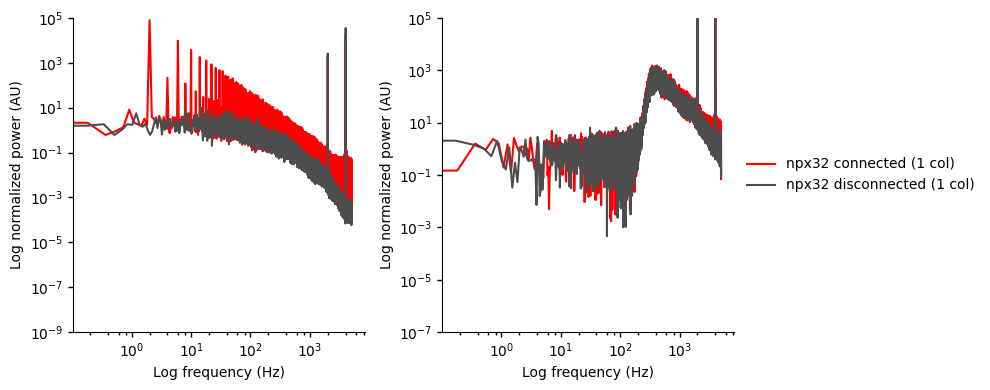

In [27]:
# takes 2 mins

fig, axes = plt.subplots(1,2,figsize=(10,4))

# pick first the first frequencies
# amplitude to divide by
NORM_WIND = np.arange(0,5,1)

# 32
psd, _, freq = downsample_power_data(POWER_PATH_32)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean/np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[1,0,0]);
del psd; del freq

# 32
psd, _, freq = downsample_power_data(POWER_PATH_32_DISCO)
psd_mean = np.mean(psd, axis=0)
norm_psd = psd_mean/np.mean(psd_mean[NORM_WIND])
axes[0].plot(freq, norm_psd, color=[0.3,0.3,0.3]);
del psd; del freq


axes[0].set_xlabel("Log frequency (Hz)");
axes[0].set_ylabel("Log normalized power (AU)");
axes[0].set_yscale("log");
axes[0].set_xscale("log");
axes[0].spines[['right', 'top']].set_visible(False);
axes[0].set_ylim([1e-9, 1e5]);

# show minor ticks
axes[0].tick_params(which='both', width=1)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
axes[0].xaxis.set_major_locator(locmaj)    
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
axes[0].xaxis.set_minor_locator(locmin)
axes[0].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# preprocessed
# 32
_, psd_pre, freq = downsample_power_data(POWER_PATH_32)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean/np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[1,0,0], label="npx32 connected (1 col)");
del psd_pre; del freq

# 32
_, psd_pre, freq = downsample_power_data(POWER_PATH_32_DISCO)
psd_mean = np.mean(psd_pre, axis=0)
norm_psd = psd_mean/np.mean(psd_mean[NORM_WIND])
axes[1].plot(freq, norm_psd, color=[0.3,0.3,0.3], label="npx32 disconnected (1 col)");
del psd_pre; del freq


axes[1].set_xlabel("Log frequency (Hz)");
axes[1].set_ylabel("Log normalized power (AU)");
axes[1].set_yscale("log");
axes[1].set_xscale("log");
axes[1].spines[['right', 'top']].set_visible(False);
axes[1].legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5));
axes[1].set_ylim([1e-7, 1e5]);

# show minor ticks
axes[1].tick_params(which='both', width=1)
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=12)
axes[1].xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0, subs=(0.2,0.4,0.6,0.8), numticks=12)
axes[1].xaxis.set_minor_locator(locmin)
axes[1].xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.tight_layout();

# save figures
plt.savefig("figures/4_controls/pdf/powers_disconnected.pdf")
plt.savefig("figures/4_controls/svg/powers_disconnected.svg")